<div align="center">

---
# Decision Trees - ID3 [Artificial Intelligence Project]
---
</div>

<div align="center">

***
## Problem Presentation
***
</div>
    
> ADD PROBLEM PRESENTATION

<div align="center">

***
## ID3 Algorithm 
***
</div>

A well-known decision tree approach for Machine Learning is the Iterative Dichotomiser 3 (ID3) algorithm. By choosing the best characteristic at each node to partition the data depending on information gain, it recursively constructs a tree. The goal is to make the final subsets as homogeneous as possible. By choosing features that offer the greatest reduction in entropy or uncertainty, ID3 iteratively grows the tree. The procedure keeps going until a halting requirement is satisfied, like a minimum subset size or a maximum tree depth. 

The ID3 Algorithm is specifically designed for building decision trees from a given dataset. It's primary objective is to construct a tree that best explains the relationship between attributes in the data and their corresponding class labels.

**1. Selecting the Best Attribute:**
- ID3 employs the concept of entropy and information gain to determine the attribute that best separates the data. Entropy measures the impurity or randomness in the dataset.
- The algorithm calculates the entropy of each attribute and selects the one that results in the most significant information gain when used for splitting the data.

**2. Creating Tree Nodes:**
- The chosen attribute is used to split the dataset into subsets based on its distinct values.
- For each subset, ID3 recurses to find the next best attribute to further partition the data, forming branches and new nodes accordingly.

**3. Stopping Criteria:**
- The recursion continues until one of the stopping criteria is met, such as when all instances in a branch belong to the same class or when all attributes have been used for splitting.

**4. Handling Missing Values:**
- ID3 can handle missing values to prevent overfitting. While not directly included in ID3, post-processing techniques or variations like C4.5 incorporate pruning to improve the tree's generalization.

<div align="center">

***
## Mathematical Concepts of ID3 Algorithm
***
</div>

### Entropy

**Entropy** is a measure of disorder or uncertainty in a set of data. It is a tool used in ID3 to measure a dataset's disorder  or impurity. By dividing the data into as homogeneous subsets as feasible, the objective is to minimze entropy.

For a set $S$ with classes $\{c_1,\space c_2,\space ...\space,\space c_n \}$, the entropy is calculated as:

$$H(S) = \sum_{i=1}^n \space p_i \space log_2(p_i)$$

Where $p_i$ is the proportion of instances of class $c_i$ in the set.

### Information Gain

Information Gain measures how well a certain quality reduces uncertainty. ID3 splits the data at each stage, choosing the property that maximizes Information Gain. It is computes using the distinction between entropy prior to and following the split.

Information Gain measures the effectiveness of an Attribute $A$ in reducing uncertainty in set $S$

$$IG(A,S) = H(S) - \sum_{v \space \in \space values(A)} \frac{|S_v|}{|S|} \cdot H(S_v))$$

Where, $|S_v|$ is the size of the subset of $S$ for which attribute $A$ has value $v$.

### Gain Ratio (Used more in the C4.5 Algorithm)

Gain Ratio is an improvement on Information Gain that considers the inherent worth of characteristics that have a wide range of possible values. It deals with the bias of Information Gan in favor of characteristics with more pronounced values.

$$ GR(A,S) = \frac{IG(A,S)}{-\sum_{v\space\in\space values(A)} \frac{|S_v|}{|S|} \cdot log_2(\frac{|S_v|}{|S|})} $$

<div align="center">

***
## Problem's Resolution Approach
***
</div>

In order to properly develop this Project, we decided to separate it into **multiple classes**:

- **Dataset**:
  - Responsible to preprocess any given dataset. This helps to properly **format / encode the data** which is going to be later fed to the algorithm.
- **Node**:
  - Structural Data Structure used inside the ID3's algorithm.
- **Decision Tree**:
  - Class that focuses on the implementation of the ID3's Algorithm.


<div align="center">

***
## Importing Dependencies
***
</div>

In [1]:
%load_ext autoreload
%autoreload 2

# Importing Dependencies
import numpy as np
import pandas as pd
from collections import (Counter)
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split)
from sklearn.preprocessing import (LabelEncoder)
from sklearn.tree import (DecisionTreeClassifier)
from sklearn import tree

from ID3.DataVisualization import (Display_dfs_side_by_side,calc_learning_curve_points, Plot_Model_Stats)
from ID3.ModelEvaluation import (Metrics)

pd.options.display.max_columns = None
np.random.seed(1234)

<div align="center">

***
## Dataset [Class]
***
</div>

In [2]:
class Dataset:
    def __init__(self, file_path):
        # Importing and Processing the Dataframe
        self.df, self.cols, self.target_encoder = self._process_dataframe(file_path)

        # Finds the Numerical Columns inside the Dataset
        self.numerical_cols = self.df[self.cols[0:-1]].select_dtypes(include=np.number).columns.tolist()

        # Performs Binning over the Numerical Data
        self._perform_binning()

        # Gets the data and target of the dataset
        self.data, self.target = self._get_data_target()

        # Train and Test Dataframes used only for better visualization of the data
        self.Train_df, self.Test_df = None, None
        
    def _process_dataframe(self, file_path):
        # Reading the .csv file
        df = pd.read_csv(file_path, keep_default_na=False, na_values=['NaN', 'nan'])

        # Encoding the Target
        label_encoder = LabelEncoder()
        target_column = df.columns[-1]
        df[target_column] = label_encoder.fit_transform(df[target_column])

        # Try to drop a potential columns 'ID' since it does not add anything to the predictive Model
        try:
            df.drop(columns=['ID'], inplace=True)
        except:
            pass
        
        return df, df.columns, label_encoder
    
    def _perform_binning(self):
        # Binning allows to convert numerical data into categorical variables (puts the values in grouped intervals)
        for numerical_column in self.numerical_cols:
            self.df[numerical_column] = pd.qcut(self.df[numerical_column], q=[0, .3, .7, 1])
            # self.df[numerical_column] = pd.qcut(self.df[numerical_column], q=[0, .25, .5, .75, 1])

    def _get_data_target(self):
        # Filtering columns
        X_Cols = self.cols[0:-1]
        y_Col = self.cols[-1]

        # Partitioning the Data
        X = self.df[X_Cols].to_numpy()
        y = self.df[y_Col].squeeze().to_numpy()

        return X, y

    def _process_train_test_split(self, X_train, X_test, y_train, y_test):
        # Convert the Train set into a DataFrame
        X_train_df = pd.DataFrame(X_train, columns=self.df.columns[0:-1])
        y_train_srs = pd.Series(self.target_encoder.inverse_transform(y_train), name=self.df.columns[-1])
        self.Train_df = pd.concat([X_train_df, y_train_srs], axis=1)
        
        # Convert the Test set into a DataFrame
        X_test_df = pd.DataFrame(X_test, columns=self.df.columns[0:-1])
        y_test_srs = pd.Series(self.target_encoder.inverse_transform(y_test), name=self.df.columns[-1])
        self.Test_df = pd.concat([X_test_df, y_test_srs], axis=1)
    
    def train_test_split(self, X=None, y=None, test_size=0.3):
        # Setting Default Values
        X = self.data if X is None else X
        y = self.target if y is None else y

        # Splitting the Data
        (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=test_size, random_state=13, shuffle=True, stratify=y)

        # Updating the Test and Train Dataframes
        self._process_train_test_split(X_train, X_test, y_train, y_test)
        
        return (X_train, X_test, y_train, y_test)

<div align="center">

***
## Decision Tree - ID3 [Class]
***
</div>

In [3]:
class Node:
    def __init__(self, feature=None, information_gain=None, threshold=None, children=None, *, value=None, correct_cases=None, total_cases=None):
        # Feature and Threshold this node was divided with
        self.feature = feature
        self.threshold = threshold
        self.information_gain = information_gain
        
        # Defining the Children
        self.children = [] if children is None else children

        # Value of a Node -> Determines if it is a Node or not
        self.value = value
        self.correct_cases = correct_cases
        self.total_cases = total_cases

    def is_leaf(self):
        # If a Node does not have a Value then it is not a Leaf
        return self.value is not None

In [4]:
class DecisionTree:
    def __init__(self, min_samples_split=1, max_depth=20, n_features=None):
        # Amount of Samples needed to perform a split
        self.min_samples_split = min_samples_split

        # Max depth of the decision tree
        self.max_depth = max_depth

        # Number of features (X) - Helps add some randomness to the Tree
        self.n_features = n_features

        # Defining a root - will later help to traverse the tree
        self.root = None

    def _most_common_label(self, y):
        # Creating a Counter
        counter = Counter(y)
        
        # Getting the Most Common Value
        value = counter.most_common(1)[0][0]

        # Returns most common value
        return value

    def _entropy(self, y):
        # The Bincount method creates a numpy array with the occurences of each value.
        # The index of the array is the number and it's value in the array corresponds to the amount of times it appears in y
        occurences = np.bincount(y)

        # Calculating every pi for every X in the previous array
        ps = occurences / len(y)

        # Returning the Entropy Value
        return - sum(p * np.log2(p) for p in ps if p > 0)

    def _split(self, Attribute_Column, Thresholds):
        entries_indices = [np.argwhere(Attribute_Column == value).flatten() for value in Thresholds]
        return entries_indices

    def _information_gain(self, y, Attribute_Column, Thresholds):
        # Calculate Parent Entropy
        parent_entropy = self._entropy(y)

        # Getting unique values in the Column
        unique_thresholds = self._split(Attribute_Column, Thresholds)

        # Calculating the entropies for all the potential children (and the size for each partition)
        children_entropies = [(y[threshold_idx].size, self._entropy(y[threshold_idx])) for threshold_idx in unique_thresholds]

        # Size of the original set
        n = len(y)

        # Initializing the summation to subtract to the parent_entropy in order to obtain the information gain
        sum_child_entropies = 0
        for partition_size, child_entropy in children_entropies:
            sum_child_entropies += ((partition_size / n) * child_entropy)

        # return (parent_entropy - sum_child_entropies) / len(unique_thresholds)
        return (parent_entropy - sum_child_entropies)

    def _gain_ratio(self, y, Attribute_Column, Thresholds):
        info_gain = self._information_gain(y, Attribute_Column, Thresholds)
        n = len(y)
        intrinsic_information = 0
        unique_thresholds = self._split(Attribute_Column, Thresholds)

        for unique_threshold in unique_thresholds:
            prop = len(unique_threshold)/n
            intrinsic_information += (prop) * np.log2(prop)
        
        return info_gain / (-intrinsic_information)
        
    def _best_split(self, X, y, feature_indices):
        best_information_gain = -1
        best_feature_idx = None

        for feat_idx in feature_indices:
            attribute_column = X[:, feat_idx]
            thresholds = np.unique(attribute_column)
            
            info_gain = self._information_gain(y, attribute_column, thresholds)
            # info_gain = self._gain_ratio(y, attribute_column, thresholds)
            
            if (info_gain > best_information_gain):
                best_information_gain = info_gain
                best_feature_idx = feat_idx

        return best_feature_idx, best_information_gain

    def _grow_tree(self, X, y, feature_indices, threshold=None, depth=0):
        n_samples, n_features = X.shape
        n_labels = np.unique(y).size
        
        feature_idx, info_gain = self._best_split(X, y, feature_indices)

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split or info_gain <= 0):
            most_common_label = self._most_common_label(y)
            return Node(threshold=threshold, value=most_common_label, correct_cases=sum(y == most_common_label), total_cases=len(y))
        
        feature_thresholds = np.unique(X[:, feature_idx])
        
        children = []
        for value in feature_thresholds:
            subset_indices = np.where(X[:, feature_idx] == value)[0]

            subset_X = X[subset_indices, :]
            subset_y = y[subset_indices]

            subtree = self._grow_tree(subset_X, subset_y, np.delete(feature_indices, np.where(feature_indices == feature_idx)), value, depth + 1)
            children.append(subtree)

        return Node(feature_idx, info_gain, threshold, children, total_cases=len(y))

    def fit(self, X, y):
        # Making sure that the amount of features does not surpass the ones available
        if not self.n_features:
            self.n_features = X.shape[1]
        else:
            self.n_features = min(X.shape[1], self.n_features)
    
        # Creating a Tree Recursively
        self.root = self._grow_tree(X, y, np.arange(self.n_features))
    
    def _traverse_tree(self, X, node:Node):
        # Traverses the Tree until we reached a leaf node -> which will determine the classification label
        if (node.is_leaf()):
            return node.value

        feature_value = X[node.feature]

        for child in node.children:
                if (type(child.threshold) == pd._libs.interval.Interval and (feature_value in child.threshold or feature_value == child.threshold)):
                    return self._traverse_tree(X, child)
                elif (feature_value == child.threshold):
                    return self._traverse_tree(X, child)

    def predict(self, X):
        # Predicts the Label given an Input
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def score(self, y_pred, y_true):
        # Simple Accuracy
        return sum(y_pred == y_true) / len(y_true)

    def print_tree(self, ds:Dataset, node=None, indent=" "):
        if node is None:
            node = self.root
            if node is None:
                raise Exception("[Unfit Model]")

        assert(isinstance(self.root, Node))

        # Check if we have a leaf node
        if node.is_leaf():
            print(indent + f"Leaf: Class {ds.target_encoder.inverse_transform([node.value])[0]} [{node.correct_cases}/{node.total_cases}]")
        else:
            # Print current node's feature and information gain
            print(indent + f"Node: {ds.cols[node.feature]} (IG: {node.information_gain:.2f})")
            
            # Iterate over all children of the current node
            for child in node.children:
                # Print the branch and the threshold value
                print(indent + f"Branch: {ds.cols[node.feature]} == {child.threshold}")
                # Recursive call to print each subtree
                self.print_tree(ds, child, indent + "  ")

    def plot_tree(self, ds:Dataset, node, parent_name, graph, counter, decision=None):
        # Base case: leaf node
        if node.is_leaf():
            leaf_name = f'leaf_{counter}'
            graph.node(leaf_name, label=f"{ds.target_encoder.inverse_transform([node.value])[0]} [{node.correct_cases}/{node.total_cases}]", shape='box')
            graph.edge(parent_name, leaf_name, label=decision)
            return counter + 1

        # Displaying Case Analysis in the current node
        feature = ds.cols[node.feature]
        attribute_name = f"{feature} [{node.total_cases}]"
        
        # Adding the Labels to the nodes and braches
        internal_name = f'internal_{counter}'
        graph.node(internal_name, label=attribute_name)
        if parent_name is not None:
            graph.edge(parent_name, internal_name, label=decision)

        counter += 1
        
        for child in node.children:
            label = f'{child.threshold}'
            counter = self.plot_tree(ds, child, internal_name, graph, counter, label)

        return counter

    def visualize_tree(self, dataset, file_path=None):
        graph = graphviz.Digraph(format='png', node_attr={'color': 'lightblue2', 'style': 'filled'})
        self.plot_tree(dataset, self.root, None, graph, 0)
        if (file_path is not None):
            graph.render(file_path)
        return graph

<div align="center">

***
## Model Evaluation upon the Datasets
***
</div>

<div align="center">

___
### Restaurant Dataset
___
</div>

---
#### Data Preprocessing
---

In [5]:
# Loading the Data
restaurant = Dataset('./Datasets/restaurant.csv')
restaurant.df

,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,Class
0,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,1
1,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,0
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,1
3,Yes,No,Yes,Yes,Full,$,No,No,Thai,10-30,1
4,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,0
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,1
6,No,Yes,No,No,None,$,Yes,No,Burger,0-10,0
7,No,No,No,Yes,Some,$$,Yes,Yes,Thai,0-10,1
8,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,0
9,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,0


In [6]:
# Example of how the data looks like before being fed to the algorithm
print(f"Data = {list(restaurant.data[0])}")
print(f"Target = {restaurant.target[0]}")

Data = ['Yes', 'No', 'No', 'Yes', 'Some', '$$$', 'No', 'Yes', 'French', '0-10']
Target = 1


---
#### Training Phase
---

In [7]:
# Splitting the Data
x_train, x_test, y_train, y_test = restaurant.train_test_split()
Display_dfs_side_by_side([restaurant.Train_df, restaurant.Test_df], ['$Train \space Set$', '$Test \space Set$'])

,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,Class
0,Yes,No,Yes,No,Full,$$$,No,Yes,French,>60,No
1,No,Yes,Yes,No,Full,$,Yes,No,Burger,>60,No
2,No,Yes,No,No,Some,$,No,No,Burger,0-10,Yes
3,Yes,Yes,Yes,Yes,Full,$,No,No,Burger,30-60,Yes
4,Yes,No,No,Yes,Some,$$$,No,Yes,French,0-10,Yes
5,No,Yes,No,Yes,Some,$$,Yes,Yes,Italian,0-10,Yes
6,Yes,Yes,Yes,Yes,Full,$$$,No,Yes,Italian,10-30,No
7,No,No,No,No,None,$,No,No,Thai,0-10,No
,Alt,Bar,Fri,Hun,Pat,Price,Rain,Res,Type,Est,Class
0,Yes,No,No,Yes,Full,$,No,No,Thai,30-60,No


In [8]:
# Training the Decision Tree
dt = DecisionTree()
dt.fit(x_train, y_train)

In [9]:
# Evaluate Train
y_pred = dt.predict(x_train)
dt.score(y_pred, y_train)

1.0

Since the Model obtained a Accuracy Score of 100% in the Training Step, we can conclude that it learned everything it could from the information of the train set.

    Let's Visualize what the Trained Model looks like.

In [10]:
# Writing the Tree's Configuration in the Terminal
dt.print_tree(restaurant)

 Node: Pat (IG: 0.59)
 Branch: Pat == Full
   Node: Est (IG: 0.81)
   Branch: Est == 10-30
     Leaf: Class No [1/1]
   Branch: Est == 30-60
     Leaf: Class Yes [1/1]
   Branch: Est == >60
     Leaf: Class No [2/2]
 Branch: Pat == None
   Leaf: Class No [1/1]
 Branch: Pat == Some
   Leaf: Class Yes [3/3]


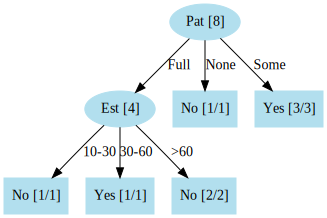

In [11]:
# Plot Decision Tree
dt.visualize_tree(restaurant)

Furthermore, let's try to feed new examples to see how the Model performns against extra data entries.

In [12]:
# Testing the Decision Tree with new Examples
input_values = np.array([['Yes', 'No', 'Yes', 'No', 'Some', '$$$', 'No', 'Yes', 'French', '>60'],
                        ['No', 'No', 'No', 'Yes', 'Full', '$$', 'No', 'Yes', 'French', '>60']])

# Predicting output values
output_values = dt.predict(input_values)

# Decoding target values
decoded_values = list(restaurant.target_encoder.inverse_transform(output_values))

# Print Results
for idx, input_val in enumerate(input_values):
    print(list(restaurant.df.columns[:-1]))
    print(input_val)
    print(decoded_values[idx], "\n")

['Alt', 'Bar', 'Fri', 'Hun', 'Pat', 'Price', 'Rain', 'Res', 'Type', 'Est']
['Yes' 'No' 'Yes' 'No' 'Some' '$$$' 'No' 'Yes' 'French' '>60']
Yes 

['Alt', 'Bar', 'Fri', 'Hun', 'Pat', 'Price', 'Rain', 'Res', 'Type', 'Est']
['No' 'No' 'No' 'Yes' 'Full' '$$' 'No' 'Yes' 'French' '>60']
No 



---
#### Testing Phase [Model Evaluation]
---

In [13]:
# Testing the Model with a few Metrics
y_pred = dt.predict(x_test)
restaurant_metrics = Metrics(y_pred, y_test)
restaurant_metrics.calculate_metrics()

,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score
0,0.5,0.5,0.5,0.5,0.5


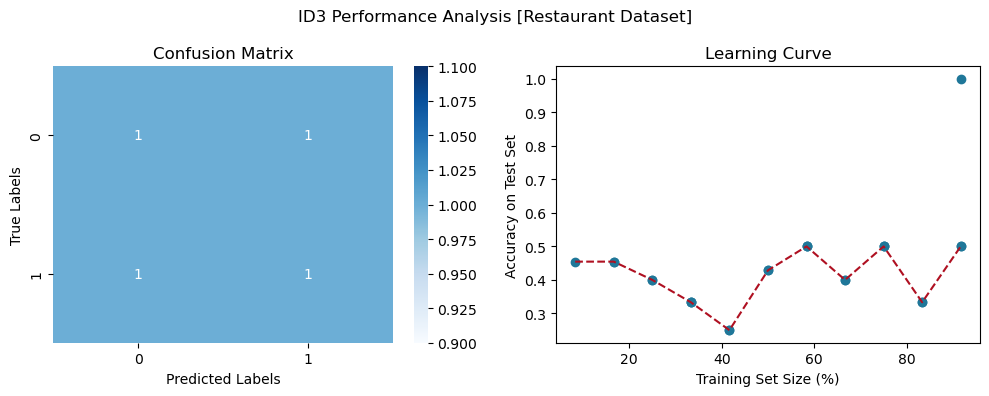

In [14]:
# Plotting the Confusion Matrix and the Learning Curve
points = calc_learning_curve_points(DecisionTree, restaurant.data, restaurant.target)
Plot_Model_Stats(dt, points, x_test, y_test, Title='ID3 Performance Analysis [Restaurant Dataset]')

As we can see from the results obtained from the model's training over the partitioned the data (into train and test sets) we can conclude:

- The Algorithm fails to properly classify half of the test cases which lead to the previous 50% Accuracy.
- The AUC (Area under Curve) coincides with the chance level line which means that the trained model does not perform better nor worse than random guessing.

---
#### Further Considerations
---

If we induce a Decision Tree with the total information inside the Dataset we would obtain the following model:

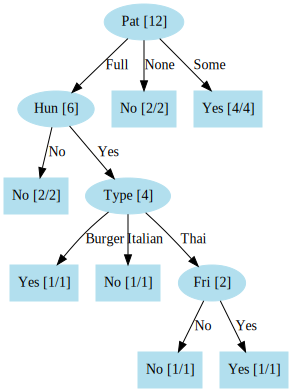

In [15]:
# Training a new Decision Tree with all the information available
dt = DecisionTree()
dt.fit(restaurant.data, restaurant.target)
dt.visualize_tree(restaurant)

As we can observe, despite the increse on the amount of training information, the algorithm overfits. Therefore, this case serves only as to better visualize a decision tree capable of handling the information inside the dataset and not to be used inside real-world applications since it will certainly produce bad results upon unseen data.

<div align="center">

---
### Weather Dataset
---
</div>

---
#### Data Preprocessing
---

In [16]:
# Loading the Data
weather = Dataset('./Datasets/weather.csv')
weather.df

,Weather,Temp,Humidity,Windy,Play
0,sunny,"(75.5, 85.0]","(74.5, 90.0]",False,0
1,sunny,"(75.5, 85.0]","(74.5, 90.0]",True,0
2,overcast,"(75.5, 85.0]","(74.5, 90.0]",False,1
3,rainy,"(69.9, 75.5]","(90.0, 96.0]",False,1
4,rainy,"(63.999, 69.9]","(74.5, 90.0]",False,1
5,rainy,"(63.999, 69.9]","(64.999, 74.5]",True,0
6,overcast,"(63.999, 69.9]","(64.999, 74.5]",True,1
7,sunny,"(69.9, 75.5]","(90.0, 96.0]",False,0
8,sunny,"(63.999, 69.9]","(64.999, 74.5]",False,1
9,rainy,"(69.9, 75.5]","(74.5, 90.0]",False,1


In [17]:
# Example of how the data looks like before being fed to the algorithm
print(f"Data = {list(weather.data[0])}")
print(f"Target = {weather.target[0]}")

Data = ['sunny', Interval(75.5, 85.0, closed='right'), Interval(74.5, 90.0, closed='right'), False]
Target = 0


In [18]:
# Inspecting the Variable Type of the binned variables
type(weather.data[0][1])

pandas._libs.interval.Interval

---
#### Training Phase
---

In [19]:
# Splitting the Data
x_train, x_test, y_train, y_test = weather.train_test_split()
Display_dfs_side_by_side([weather.Train_df, weather.Test_df], ['$Train \space Set$', '$Test \space Set$'])

,Weather,Temp,Humidity,Windy,Play
0,rainy,"(69.9, 75.5]","(74.5, 90.0]",False,yes
1,overcast,"(75.5, 85.0]","(74.5, 90.0]",False,yes
2,sunny,"(75.5, 85.0]","(74.5, 90.0]",True,no
3,sunny,"(69.9, 75.5]","(90.0, 96.0]",False,no
4,rainy,"(69.9, 75.5]","(90.0, 96.0]",False,yes
5,overcast,"(63.999, 69.9]","(64.999, 74.5]",True,yes
6,overcast,"(75.5, 85.0]","(74.5, 90.0]",False,yes
7,overcast,"(69.9, 75.5]","(74.5, 90.0]",True,yes
8,rainy,"(69.9, 75.5]","(90.0, 96.0]",True,no
,Weather,Temp,Humidity,Windy,Play


In [20]:
# Training the Decision Tree
dt = DecisionTree()
dt.fit(x_train, y_train)

In [21]:
# Evaluate Train
y_pred = dt.predict(x_train)
dt.score(y_pred, y_train)

1.0

Since the Model obtained a Accuracy Score of 100% in the Training Step, we can conclude that it learned everything it could from the information of the train set.

    Let's Visualize what the Trained Model looks like.

In [22]:
# Writing the Tree's Configuration in the Terminal
dt.print_tree(weather)

 Node: Weather (IG: 0.61)
 Branch: Weather == overcast
   Leaf: Class yes [4/4]
 Branch: Weather == rainy
   Node: Windy (IG: 0.92)
   Branch: Windy == False
     Leaf: Class yes [2/2]
   Branch: Windy == True
     Leaf: Class no [1/1]
 Branch: Weather == sunny
   Leaf: Class no [2/2]


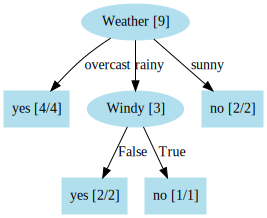

In [23]:
# Plot Decision Tree
dt.visualize_tree(weather)

Furthermore, let's try to feed new examples to see how the Model performns against extra data entries.

In [24]:
# Testing the Decision Tree with new Examples
input_values = np.array([['overcast', 70.0, 80.0, False],
                         ['rainy', 70.0, 80.0, False]])

# Predicting output values
output_values = dt.predict(input_values)

print(output_values)

# Decoding target values
decoded_values = list(weather.target_encoder.inverse_transform(output_values))

# Print Results
for idx, input_val in enumerate(input_values):
    print(list(weather.df.columns[:-1]))
    print(input_val)
    print(decoded_values[idx], "\n")

[1 None]


TypeError: '>' not supported between instances of 'int' and 'NoneType'

---
#### Testing Phase [Model Evaluation]
---

In [25]:
# Testing the Model with a few Metrics
y_pred = dt.predict(x_test)
weather_metrics = Metrics(y_pred, y_test)
weather_metrics.calculate_metrics()

,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score
0,0.6,0.666667,0.8,0.6,0.566667


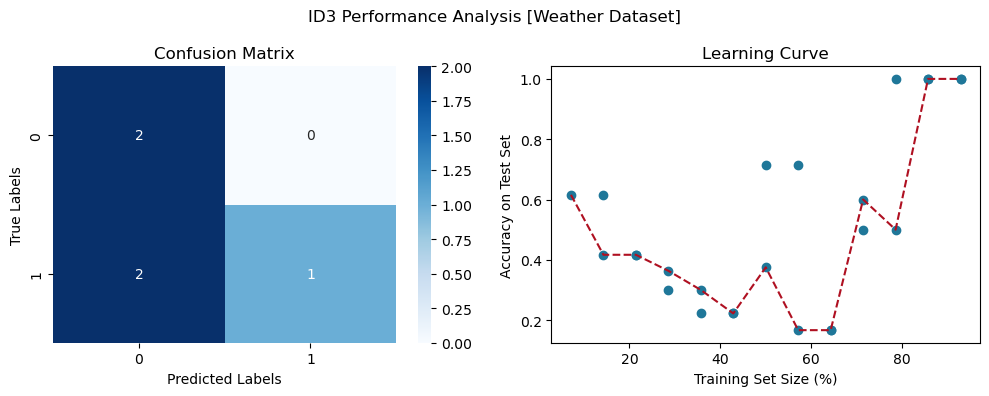

In [26]:
# Plotting the Confusion Matrix and the Learning Curve
points = calc_learning_curve_points(DecisionTree, weather.data, weather.target)
Plot_Model_Stats(dt, points, x_test, y_test, Title='ID3 Performance Analysis [Weather Dataset]')

# ADD TEXT

As we can see from the results obtained from the model's training over the partitioned the data (into train and test sets) we can conclude:

- XXX
- XXX

<div align="center"> 

---
### Iris Dataset
---
</div>

---
#### Data Preprocessing
---

In [27]:
# Loading the Data
iris = Dataset('./Datasets/iris.csv')
iris.df

,sepallength,sepalwidth,petallength,petalwidth,class
0,"(4.2989999999999995, 5.27]","(3.2, 4.4]","(0.999, 1.7]","(0.099, 0.4]",0
1,"(4.2989999999999995, 5.27]","(2.8, 3.2]","(0.999, 1.7]","(0.099, 0.4]",0
2,"(4.2989999999999995, 5.27]","(2.8, 3.2]","(0.999, 1.7]","(0.099, 0.4]",0
3,"(4.2989999999999995, 5.27]","(2.8, 3.2]","(0.999, 1.7]","(0.099, 0.4]",0
4,"(4.2989999999999995, 5.27]","(3.2, 4.4]","(0.999, 1.7]","(0.099, 0.4]",0
...,...,...,...,...,...
145,"(6.3, 7.9]","(2.8, 3.2]","(5.0, 6.9]","(1.8, 2.5]",2
146,"(5.27, 6.3]","(1.999, 2.8]","(1.7, 5.0]","(1.8, 2.5]",2
147,"(6.3, 7.9]","(2.8, 3.2]","(5.0, 6.9]","(1.8, 2.5]",2
148,"(5.27, 6.3]","(3.2, 4.4]","(5.0, 6.9]","(1.8, 2.5]",2


In [28]:
# Example of how the data looks like before being fed to the algorithm
print(f"Data = {list(iris.data[0])}")
print(f"Target = {iris.target[0]}")

Data = [Interval(4.2989999999999995, 5.27, closed='right'), Interval(3.2, 4.4, closed='right'), Interval(0.999, 1.7, closed='right'), Interval(0.099, 0.4, closed='right')]
Target = 0


In [29]:
# Inspecting the Variable Type of the binned variables
type(iris.data[0][1])

pandas._libs.interval.Interval

---
#### Training Phase
---

In [30]:
# Splitting the Data
x_train, x_test, y_train, y_test = iris.train_test_split()
Display_dfs_side_by_side([iris.Train_df, iris.Test_df], ['$Train \space Set$', '$Test \space Set$'])

,sepallength,sepalwidth,petallength,petalwidth,class
0,"(5.27, 6.3]","(1.999, 2.8]","(1.7, 5.0]","(0.4, 1.8]",Iris-versicolor
1,"(4.2989999999999995, 5.27]","(3.2, 4.4]","(0.999, 1.7]","(0.099, 0.4]",Iris-setosa
2,"(4.2989999999999995, 5.27]","(3.2, 4.4]","(1.7, 5.0]","(0.099, 0.4]",Iris-setosa
3,"(6.3, 7.9]","(1.999, 2.8]","(5.0, 6.9]","(0.4, 1.8]",Iris-virginica
4,"(5.27, 6.3]","(2.8, 3.2]","(1.7, 5.0]","(0.4, 1.8]",Iris-versicolor
5,"(4.2989999999999995, 5.27]","(3.2, 4.4]","(0.999, 1.7]","(0.4, 1.8]",Iris-setosa
6,"(5.27, 6.3]","(2.8, 3.2]","(1.7, 5.0]","(0.4, 1.8]",Iris-virginica
7,"(4.2989999999999995, 5.27]","(2.8, 3.2]","(0.999, 1.7]","(0.099, 0.4]",Iris-setosa
8,"(6.3, 7.9]","(2.8, 3.2]","(5.0, 6.9]","(1.8, 2.5]",Iris-virginica
9,"(5.27, 6.3]","(1.999, 2.8]","(1.7, 5.0]","(0.4, 1.8]",Iris-versicolor


In [31]:
# Training the Decision Tree
dt = DecisionTree()
dt.fit(x_train, y_train)

In [32]:
# Train
y_pred = dt.predict(x_train)
dt.score(y_pred, y_train)

0.9428571428571428

Since the Model obtained a Accuracy Score of 94.29% in the Training Step, we can infer that it learned almost everything it could from the information inside the train set.

    Let's Visualize what the Trained Model looks like.

In [33]:
# Writing the Tree's Configuration in the Terminal
dt.print_tree(iris)

 Node: petallength (IG: 1.13)
 Branch: petallength == (0.999, 1.7]
   Leaf: Class Iris-setosa [33/33]
 Branch: petallength == (1.7, 5.0]
   Node: petalwidth (IG: 0.45)
   Branch: petalwidth == (0.099, 0.4]
     Leaf: Class Iris-setosa [2/2]
   Branch: petalwidth == (0.4, 1.8]
     Node: sepallength (IG: 0.03)
     Branch: sepallength == (4.2989999999999995, 5.27]
       Leaf: Class Iris-versicolor [5/6]
     Branch: sepallength == (5.27, 6.3]
       Node: sepalwidth (IG: 0.02)
       Branch: sepalwidth == (1.999, 2.8]
         Leaf: Class Iris-versicolor [13/16]
       Branch: sepalwidth == (2.8, 3.2]
         Leaf: Class Iris-versicolor [9/10]
       Branch: sepalwidth == (3.2, 4.4]
         Leaf: Class Iris-versicolor [1/1]
     Branch: sepallength == (6.3, 7.9]
       Leaf: Class Iris-versicolor [6/6]
   Branch: petalwidth == (1.8, 2.5]
     Leaf: Class Iris-virginica [3/3]
 Branch: petallength == (5.0, 6.9]
   Node: sepallength (IG: 0.07)
   Branch: sepallength == (5.27, 6.3]
     

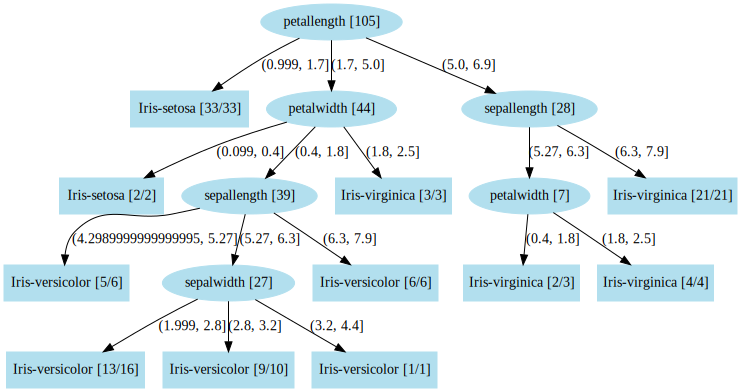

In [34]:
# Plot Decision Tree
dt.visualize_tree(iris)

Furthermore, let's try to feed new examples to see how the Model performns against extra data entries.

In [35]:
# Testing the Decision Tree with new Examples
input_values = np.array([[5.3, 2.1, 1.0, 1.2],
                         [4.5, 3.7, 2.3, 1.9]])

# Predicting output values
output_values = dt.predict(input_values)

# Decoding target values
decoded_values = list(iris.target_encoder.inverse_transform(output_values))

# Print Results
for idx, input_val in enumerate(input_values):
    print(list(iris.df.columns[:-1]))
    print(input_val)
    print(decoded_values[idx], "\n")

['sepallength', 'sepalwidth', 'petallength', 'petalwidth']
[5.3 2.1 1.  1.2]
Iris-setosa 

['sepallength', 'sepalwidth', 'petallength', 'petalwidth']
[4.5 3.7 2.3 1.9]
Iris-virginica 



---
#### Testing Phase [Model Evaluation]
---

In [36]:
# Testing the Model with a few Metrics
y_pred = dt.predict(x_test)
iris_metrics = Metrics(y_pred, y_test)
iris_metrics.calculate_metrics()

,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score
0,0.977778,0.977778,0.979167,0.977778,0.977753


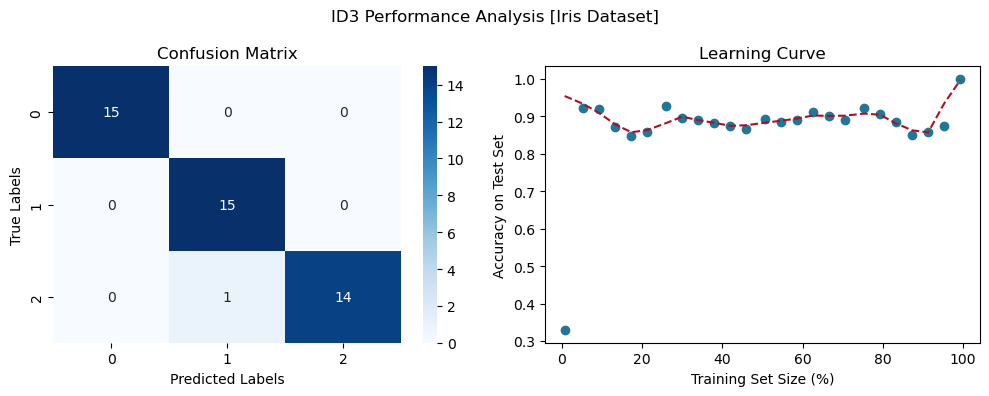

In [37]:
# Plotting the Confusion Matrix and the Learning Curve
points = calc_learning_curve_points(DecisionTree, iris.data, iris.target)
Plot_Model_Stats(dt, points, x_test, y_test, Title='ID3 Performance Analysis [Iris Dataset]')

# ADD TEXT

As we can see from the results obtained from the model's training over the partitioned the data (into train and test sets) we can conclude:

- XXX
- XXX

<div align="center">

---
### Connect-Four Dataset 
---
</div>

<div align="center">

***
## Advantages and Disadvantages of ID3
***
</div>

### __Advantages__

- **Interpretability**: Decision Trees generated by ID3 are **easily interpretable**, making them usefull for explaining decisions to non-technical stakeholders
- **Handles Categorical Data**: ID3 can effectively **handle categorical attributes** without explicit data preprocessing steps
- **Not Computationally Expensive**: The Algorithm is relatively straightforward and **computationally less expensive** compared to some complex models

### __Disadvantages__

- **Overfitting**: ID3 tends to create complex trees that may **overfit over the training data**, impacting its performance upon new unseen information
- **Sensitive to Noise**: Noise or outliers in the data can lead to the **creation of non-optimal or incorrect splits**
- **Exclusive to Binary Trees**: ID3 only constructs **binary trees** which **limits** its ability to **express more complex relationships** within the data


<div align="center">

***
## Conclusion
***
</div>

The **ID3 Algorithm** laid the groundwork for **decision tree learning**, providing a robust framework for understanding **attribute selection** and **recursive partitioning**. Despite its limitations, ID3's simplicity and interpretability have paved the way for more sophisticated algorithms that address its drawbacks while retaining its essence.

As **Machine Learning** continues to evolve, the ID3 Algorithm remains a **crucial piece** in the mosaic of tree-based methods, serving as a stepping stone for developing **more advanced and accurate models** in the quest for **efficient data analysis and pattern recognition**.


<div align="center">

***
## Bibliographic References
***
</div>

1. Geeks For Geeks (2023). __*Decision Tree Algorithms*__. Available [here](https://www.geeksforgeeks.org/decision-tree-algorithms/#id3-iterative-dichotomiser-3)
2. Geeks For Geeks (2024). __*Iteratice Dichotomiser 3 (ID3) Algorithm From Scratch*__. Available [here](https://www.geeksforgeeks.org/iterative-dichotomiser-3-id3-algorithm-from-scratch/)
3. Tung.M.Phung (2020). __*Information Gain, Gain Ratio and Gini Index*__. Available [here](https://tungmphung.com/information-gain-gain-ratio-and-gini-index/)
4. https://neptune.ai/blog/balanced-accuracy
5. https://www.geeksforgeeks.org/confusion-matrix-machine-learning/

___
## Video Presentation (YouTube Video)

Moreover, you can find the **Video** for our **Project's Presentation [here](https://youtu.be/dQw4w9WgXcQ?si=NfwpqDkOwLRY6tRQ)**
___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@up.pt`
    - [Maximino Canhola](https://github.com/MaximinoCanhola) &#8594; `up201909805@up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@up.pt`